# Ingestion and Preprocessing for Air Quality Experiments

# Experiment Configuration

In [1]:
# ========== EXPERIMENT CONFIGURATION ==========
# Change these variables to configure your experiment

EXPERIMENT_NAME = "Two Years with Satellite Data"
EXPERIMENT_DESCRIPTION = "Contains GOES and TEMPO data"
EXPERIMENT_ID = "two_years_sat_data"

# Data parameters
START_DATE = "2023-08-02-00"
END_DATE = "2025-08-02-00"
TRAIN_SPLIT, VALID_SPLIT, TEST_SPLIT = 0.70, 0.15, 0.15

print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Description: {EXPERIMENT_DESCRIPTION}")
print(f"Date Range: {START_DATE} to {END_DATE}")

Experiment: Two Years with Satellite Data
Description: Contains GOES and TEMPO data
Date Range: 2023-08-02-00 to 2025-08-02-00


# Data Parameters

In [2]:
# Define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# Input data shape
dim = 40
frames_per_sample = 5

print(f"{extent}")
print(f"Grid dimension: {dim}x{dim}")
print(f"Frames per sample: {frames_per_sample}")

(-118.75, -117.0, 33.5, 34.5)
Grid dimension: 40x40
Frames per sample: 5


# Data Ingestion and Preprocessing

In [3]:
# Python nonsense that allows you to import from sibling directories
import sys
sys.path.append("../..")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

import pandas as pd
from dotenv import load_dotenv

# Import the new PWWB implementation and dataset manager
from libs.pwwb import PWWBData
from libs.pwwb.utils.dataset_manager import create_dataset_manager

# Import the AirNow data class
from libs.airnowdata import AirNowData
from libs.hrrrdata import HRRRData
from libs.goesdata import GOESData

# Import utils
import libs.pwwb.utils.dataset as utils
# Load environment variables (API keys, credentials)
load_dotenv();

/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-08 21:32:59.816071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754713979.826713   90365 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754713979.830263   90365 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

# Create output directory for results
output_dir = f"experiment_output/{EXPERIMENT_ID}"
os.makedirs(output_dir, exist_ok=True)

# Create dataset manager
manager = create_dataset_manager(
    registry_file=f"{EXPERIMENT_ID}_registry.json",
    cache_dir="data/two_years_sat_data/pwwb_cache/"
)

# List existing datasets
print("Existing datasets:")
try:
    display(manager.list_datasets())
except:
    print("No existing datasets found.")

Existing datasets:


,name,created,description,start_date,end_date,channels
0,two_years_sat_data_METAR_WIND_UV,2025-08-08T20:05:14.976026,Contains GOES and TEMPO data - METAR Wind U/V ...,2023-08-02-00,2025-08-02-00,metar


In [5]:
# Adjust end date for AirNow
end_date_adj = pd.to_datetime(END_DATE) - pd.Timedelta(hours=1)

# Dataset name and description
dataset_name = f"{EXPERIMENT_ID}_METAR_WIND_UV"
dataset_desc = f"{EXPERIMENT_DESCRIPTION} - METAR Wind U/V components"

# ========== 1. Load PWWB Data ==========
print(f"\nLoading PWWB data for {EXPERIMENT_NAME}...")

# Check if dataset already exists in the registry
if manager.get_dataset_info(dataset_name) is not None:
    print(f"Dataset '{dataset_name}' already exists, loading from cache...")
    pwwb_data = manager.load_dataset(dataset_name, PWWBData)
else:
    print(f"Dataset '{dataset_name}' not found, creating new one...")
    # Create the dataset with the specified channels
    pwwb_data = manager.create_dataset(
        name=dataset_name,
        description=dataset_desc,
        PWWBData_class=PWWBData,
        start_date=START_DATE,
        end_date=END_DATE,
        extent=extent,
        frames_per_sample=frames_per_sample,
        dim=dim,
        include_channels={
            'maiac': False,                     # Include MAIAC AOD
            'tropomi': False,        # Only include NO2 from TROPOMI
            'metar': ['METAR_Wind_U', 'METAR_Wind_V'],  # Only wind components from METAR
            'modis_fire': False,               # Exclude MODIS fire data
            'merra2': False                    # Exclude MERRA2 data
        },
        verbose=True,
        output_dir=output_dir
    )
    # Save the dataset
    pwwb_data.save_data()

# Get the data and channel info
X_pwwb = pwwb_data.data
channel_info = pwwb_data.get_channel_info()
print(f"✓ PWWB data shape: {X_pwwb.shape}")
print(f"  Channels: {channel_info['channel_names']}")

# ========== 2. Load AirNow Data ==========
print(f"\nLoading AirNow data for {EXPERIMENT_NAME}...")
airnow_data = AirNowData(
    start_date=START_DATE,
    end_date=end_date_adj,
    extent=extent,
    airnow_api_key=os.getenv('AIRNOW_API_KEY'),
    save_dir='data/two_years_sat_data/airnow_cache/airnow.json',
    processed_cache_dir='data/two_years_sat_data/airnow_cache/airnow_processed.npz',
    frames_per_sample=frames_per_sample,
    dim=dim,
    elevation_path="../../libs/inputs/elevation.npy",
    mask_path="../../libs/inputs/mask.npy",
    use_mask=False,
    force_reprocess=False
)
X_airnow = airnow_data.data
Y_targets = airnow_data.target_stations
print(f"✓ AirNow data shape: {X_airnow.shape}")
if Y_targets is not None:
    print(f"  Target stations shape: {Y_targets.shape}")
    print(f"  Number of sensors: {len(airnow_data.air_sens_loc)}")
    print(f"  Sensor names: {airnow_data.sensor_names}")
else:
    print("  No target stations available")

print(f"\nLoading GOES data")
goes_data = GOESData(
    start_date=START_DATE,
    end_date=END_DATE,
    extent=extent,
    dim=dim,
    frames_per_sample=frames_per_sample,
    save_dir='data/two_years_sat_data/goes_cache/',
    cache_path='data/two_years_sat_data/goes_cache/goes_processed.npz',
    load_cache=True,
)
X_goes = goes_data.data
print(f"✓ GOES data shape: {X_goes.shape}")


Loading PWWB data for Two Years with Satellite Data...
Dataset 'two_years_sat_data_METAR_WIND_UV' already exists, loading from cache...
Using cache prefix: two_years_sat_data_METAR_WIND_UV_
Initialized PWWBData with 17544 hourly timestamps
Date range: 2023-08-02 00:00:00 to 2025-08-01 23:00:00
Channels included: ['metar']
METAR channels: ['METAR_Wind_U', 'METAR_Wind_V']
Processing METAR meteorological data...
Loaded elevation data from ../../libs/inputs/elevation.npy
Elevation range: 0m to 100m
Initialized MetarDataSource with 2 channels: ['METAR_Wind_U', 'METAR_Wind_V']
Will fetch these raw variables: ['sped', 'drct']
Will calculate wind U/V components from speed/direction
Loading cached data from data/two_years_sat_data/pwwb_cache/two_years_sat_data_METAR_WIND_UV_metar_u_v_data.npy


I0000 00:00:1754713983.428538   90365 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6409 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Final data shape: (17535, 5, 40, 40, 2)

Channel Statistics:

Channel 0: METAR_Wind_U
  Min: 6.3550179739524815
  Max: 8.487001246065812
  Mean: 7.816446736146151
  Std: 0.3327073824933896
  Data coverage: 100.00% (1600/1600 non-zero pixels)

Channel 1: METAR_Wind_V
  Min: 3.4933812568296245
  Max: 4.3394486112010435
  Mean: 3.921195413305315
  Std: 0.10751643771407082
  Data coverage: 100.00% (1600/1600 non-zero pixels)

Final Data Shape:
  17535 samples
  5 frames per sample
  40x40 grid size
  2 channels

Data Memory Usage:
  2140.50 MB
Loaded channel info from data/two_years_sat_data/pwwb_cache/two_years_sat_data_METAR_WIND_UV_full_data_channel_info.json
Channels: ['METAR_Wind_U', 'METAR_Wind_V']
Data loaded from data/two_years_sat_data/pwwb_cache/two_years_sat_data_METAR_WIND_UV_full_data.npy
Data shape: (17535, 5, 40, 40, 2)
✓ PWWB data shape: (17535, 5, 40, 40, 2)
  Channels: ['METAR_Wind_U', 'METAR_Wind_V']

Loading AirNow data for Two Years with Satellite Data...
Mask usage di

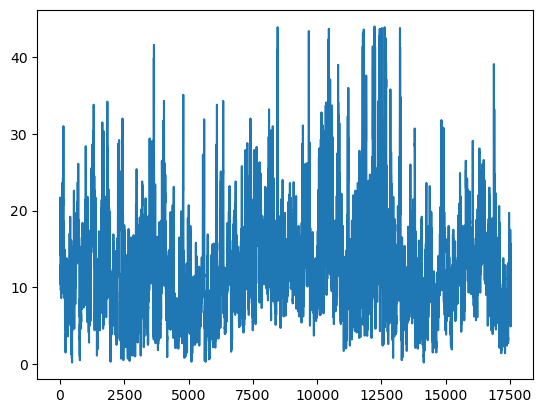

In [6]:
import matplotlib.pyplot as plt
plt.plot(Y_targets[:,0,4])

In [7]:
del airnow_data
del pwwb_data
del goes_data

# ========== 4. Create Combined Dataset ==========
print(f"\nCreating combined dataset for {EXPERIMENT_NAME}...")

# First, check shapes and find minimum timesteps
print(f"Data shapes before combining:")
print(f"  PWWB: {X_pwwb.shape}")
print(f"  GOES: {X_goes.shape}")
print(f"  AirNow: {X_airnow.shape}")
print(f"  Targets: {Y_targets.shape}")

# Combine all data sources
X_combined = np.concatenate([X_pwwb, X_goes, X_airnow], axis=-1)
print(f"Combined data shape: {X_combined.shape}")

# Display the number of channels from each source
pwwb_channels = X_pwwb.shape[4]
goes_channels = X_goes.shape[4]
airnow_channels = X_airnow.shape[4]
total_channels = X_combined.shape[4]

print(f"Channel breakdown:")
print(f"  PWWB: {pwwb_channels} channels")
print(f"  GOES: {goes_channels} channels")
print(f"  AirNow: {airnow_channels} channels")
print(f"  Total: {total_channels} channels")

# Create combined channel names
all_channel_names = channel_info['channel_names'] + ["GOES_AOD"] + ["AirNow_PM25"]
print(f"  Channel names: {all_channel_names}")


Creating combined dataset for Two Years with Satellite Data...
Data shapes before combining:
  PWWB: (17535, 5, 40, 40, 2)
  GOES: (17535, 5, 40, 40, 1)
  AirNow: (17535, 5, 40, 40, 1)
  Targets: (17535, 5, 16)
Combined data shape: (17535, 5, 40, 40, 4)
Channel breakdown:
  PWWB: 2 channels
  GOES: 1 channels
  AirNow: 1 channels
  Total: 4 channels
  Channel names: ['METAR_Wind_U', 'METAR_Wind_V', 'GOES_AOD', 'AirNow_PM25']


In [8]:
del X_pwwb
del X_airnow

print(f"\nCreating temporal train/test split for {EXPERIMENT_NAME}...")
save_path = "final_input_data/two_years_sat_data/"

print("Processing target data.")
Y_train, Y_valid, Y_test = utils.train_valid_test_split(
    Y_targets, train_size=TRAIN_SPLIT, valid_size=VALID_SPLIT, test_size=TEST_SPLIT, verbose=True
)

for i, c in enumerate(all_channel_names):
    print(f"Processing {all_channel_names[i]} data.")
    X_train, X_valid, X_test = utils.train_valid_test_split(
        X_combined[:,:,:,:,i], train_size=TRAIN_SPLIT, valid_size=VALID_SPLIT, test_size=TEST_SPLIT, verbose=True
    )
    
    X_train_scaled, X_valid_scaled, X_test_scaled = utils.std_scale(
        X_train, X_valid, X_test, True, f'data/two_years_sat_data/scalers/{c}_std_scaler.bin', verbose=True
    )

    np.save(f"{save_path}{all_channel_names[i]}_X_train.npy", X_train_scaled)
    np.save(f"{save_path}{all_channel_names[i]}_X_valid.npy", X_valid_scaled)
    np.save(f"{save_path}{all_channel_names[i]}_X_test.npy", X_test_scaled)

    print(f"Saved {all_channel_names[i]} data.\n")
    
print(f"Y_train range: {Y_train.min():.2f} to {Y_train.max():.2f}")
print(f"Y_train mean: {Y_train.mean():.2f}, std: {Y_train.std():.2f}")
np.save(f"{save_path}Y_train.npy", Y_train)
np.save(f"{save_path}Y_valid.npy", Y_valid)
np.save(f"{save_path}Y_test.npy", Y_test)


Creating temporal train/test split for Two Years with Satellite Data...
Processing target data.
🪓  Temporal split at indices 12274 and 14904:
	Training: samples 0-12273 (70%), data shape = (12274, 5, 16)
	Validation: samples 12274-14903 (15%), data shape = (2630, 5, 16)
	Testing: samples 14904-17534 (15%), data shape = (2631, 5, 16)
Processing METAR_Wind_U data.
🪓  Temporal split at indices 12274 and 14904:
	Training: samples 0-12273 (70%), data shape = (12274, 5, 40, 40)
	Validation: samples 12274-14903 (15%), data shape = (2630, 5, 40, 40)
	Testing: samples 14904-17534 (15%), data shape = (2631, 5, 40, 40)
⚖️  Scaling data and saving to {save_path}... ✅ Complete!
Saved METAR_Wind_U data.

Processing METAR_Wind_V data.
🪓  Temporal split at indices 12274 and 14904:
	Training: samples 0-12273 (70%), data shape = (12274, 5, 40, 40)
	Validation: samples 12274-14903 (15%), data shape = (2630, 5, 40, 40)
	Testing: samples 14904-17534 (15%), data shape = (2631, 5, 40, 40)
⚖️  Scaling data a

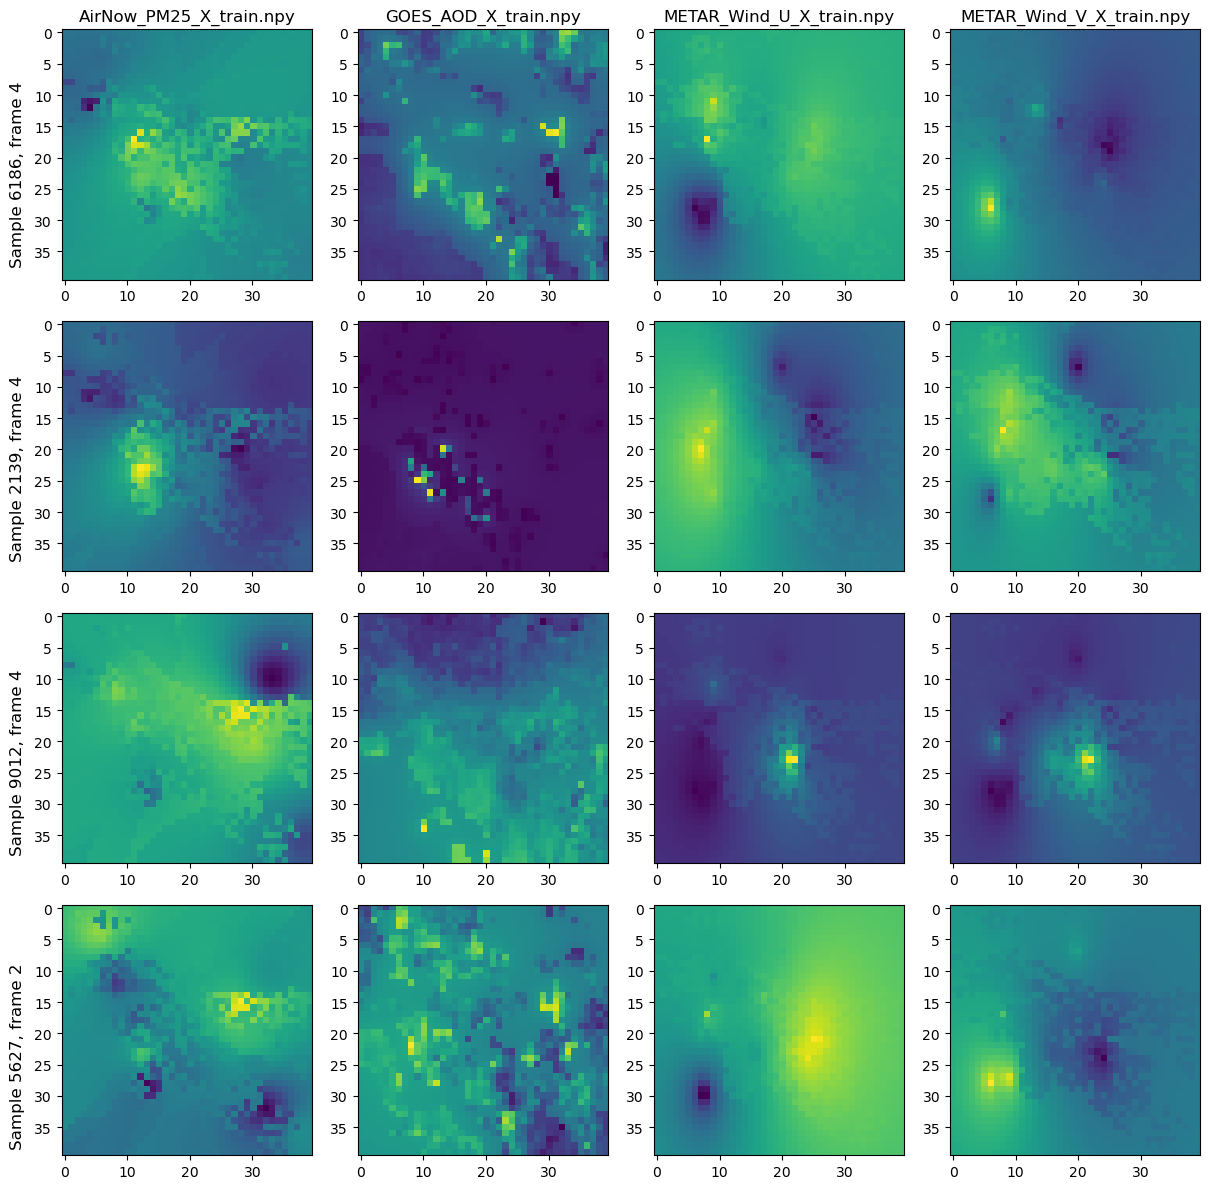

In [9]:
import matplotlib.pyplot as plt
import random

filedir = "final_input_data/two_years_sat_data/"
filepaths = ["AirNow_PM25_X_train.npy", "GOES_AOD_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy" ]

rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
for i in range(rows):
    s = random.randint(0, Y_train.shape[0] - 1)
    f = random.randint(0, frames_per_sample - 1)
    fig.text(0, 0.85 - i * 0.245, f"Sample {s}, frame {f}", va='center', ha='center',
             rotation='vertical', fontsize=12)
    for j in range(cols):
        axes[0][j].set_title(f"{filepaths[j]}")
        axes[i][j].axis('on')
        axes[i][j].imshow(np.load(f"{filedir + filepaths[j]}")[s,f,:,:])
plt.tight_layout()
plt.show()

# Timestep encoding

In [10]:
import pandas as pd
dates = pd.date_range(start=START_DATE, end=END_DATE, freq='h', inclusive='left')

In [11]:
print(
    dates[0], '\n',
    "Month:", dates.strftime('%B').unique().astype('string'), '\n',
    "Day of Week:", dates.strftime('%A').unique().astype('string'), '\n',
    "Hour:", dates.strftime('%-H').unique().astype('int'), '\n',
)

2023-08-02 00:00:00 
 Month: Index(['August', 'September', 'October', 'November', 'December', 'January',
       'February', 'March', 'April', 'May', 'June', 'July'],
      dtype='string') 
 Day of Week: Index(['Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday',
       'Tuesday'],
      dtype='string') 
 Hour: Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23],
      dtype='int64') 



In [12]:
len(dates)

17544

In [13]:
temporal_encoded_data = pd.concat(
    [
        pd.get_dummies(dates.strftime('%B'), dtype='float'), 
        pd.get_dummies(dates.strftime('%A'), dtype='float'),
        pd.get_dummies(dates.strftime('%-d'), dtype='float'),
        pd.get_dummies(dates.strftime('%-H'), dtype='float')
    ],
    axis=1
).to_numpy()
print(temporal_encoded_data)
print(temporal_encoded_data.shape)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(17544, 74)


In [14]:
temporal_encoding_X, _ = utils.sliding_window(temporal_encoded_data, 5)
print(temporal_encoding_X.shape)

(17535, 5, 74)


In [15]:
X_train, X_valid, X_test = utils.train_valid_test_split(
    temporal_encoding_X, train_size=0.7, valid_size=0.15, test_size=0.15
)

np.save(f"{save_path}Temporal_Encoding_X_train.npy", X_train)
np.save(f"{save_path}Temporal_Encoding_X_test.npy", X_test)
np.save(f"{save_path}Temporal_Encoding_X_valid.npy", X_valid)

🪓  Temporal split at indices 12274 and 14904:
	Training: samples 0-12273 (70%), data shape = (12274, 5, 74)
	Validation: samples 12274-14903 (15%), data shape = (2630, 5, 74)
	Testing: samples 14904-17534 (15%), data shape = (2631, 5, 74)
